## HomeWork к уроку 5 

> **"Первая нейронная сеть на Tensorflow"** 


In [1]:
# %tensorflow_version 2.x
%load_ext tensorboard
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as layers
import tensorflow.keras.callbacks as callbacks
import numpy as np
import matplotlib.pyplot as plt

<b>Настройка GPU</b>

In [2]:
# кастомные настройки
# установка GPU на котором будем работать
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[3], 'GPU')
tf.config.get_visible_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

##### Загрузка данных
<b>Загрузка данных</b>

In [3]:
(__x_train, y_train), (__x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [4]:
# предобработка 
x_train = (np.reshape(__x_train, (__x_train.shape[0], -1)) / 255. - 0.5) * 2
x_test = (np.reshape(__x_test, (__x_test.shape[0], -1)) / 255. - 0.5) * 2

## Код для создания и обучения модели

**Важно!** Вы можете менять код функции `get_model`, если хотите получить лучшие результаты или просто поэксперементировать.

In [5]:
def get_model(n_classes):
  activation = 'tanh'
  units = 256
  model = keras.Sequential([
    layers.Dense(units, activation=activation),
    layers.Dense(units, activation=activation),
    layers.Dense(n_classes, activation='softmax')])
  return model

In [6]:
model = get_model(10)
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=['accuracy'],
              loss='sparse_categorical_crossentropy')

In [7]:
early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience=5, 
                                         restore_best_weights=True)

tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs/'+ 'base_model')

epochs = 100
batch_size = 128
histrory = model.fit(x_train, y_train, 
                      validation_data=(x_test, y_test),
                      epochs=epochs,
                      batch_size=batch_size,
                      callbacks=[early_stopping, tensorboard])

Epoch 1/100
469/469 [==============================] - 3s 7ms/step - loss: 0.7557 - accuracy: 0.7530 - val_loss: 0.5839 - val_accuracy: 0.7908
Epoch 2/100
469/469 [==============================] - 3s 5ms/step - loss: 0.5219 - accuracy: 0.8167 - val_loss: 0.5175 - val_accuracy: 0.8164
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4724 - accuracy: 0.8329 - val_loss: 0.4845 - val_accuracy: 0.8245
Epoch 4/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4441 - accuracy: 0.8436 - val_loss: 0.4664 - val_accuracy: 0.8351
Epoch 5/100
469/469 [==============================] - 2s 5ms/step - loss: 0.4249 - accuracy: 0.8496 - val_loss: 0.4522 - val_accuracy: 0.8362
Epoch 6/100
469/469 [==============================] - 2s 5ms/step - loss: 0.4099 - accuracy: 0.8554 - val_loss: 0.4379 - val_accuracy: 0.8436
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3979 - accuracy: 0.8584 - val_loss: 0.4297 - val_accuracy: 0.8470

# Задание 1. Слой для подготовки данных

Создайте слой, который:
* получает на вход батч `(None, 28, 28)` и возвращает батч
`(None, 784)`. 
* Приводит значения интенсивности пикселей из диапазона `[0, 255]` к диапазону `[-1, 1]`.
* *Дополнительно*: сделайте слой сериализуемым.


Шаблон с кодом приведен ниже. Обучите модель с использованием этого слоя, убедитесь, что она обучается корректно.

In [8]:
class DataPreparation(layers.Layer):
  def __init__(self, *args, **kwargs):
    # Самодостаточен, дописывать не надо.
    # fix: Нужно всегда добавлять в init наследуемых объектов keras
    # *args и **kwargs. В данном случае можно вообще не писать 
    # __init__, если не будете добавлять никаких параметров для 
    # своего слоя.
    self.in_shape = kwargs.pop('input_shape')
    super().__init__(*args, **kwargs)

  def call(self, inputs):
    # Совет: чтобы получить целевую размерность, используйте все измерения 
    # тензора, кроме размерности батча, которая не определена на этапе
    # компиляции. Выполните изменение размерности как
    # tf.reshape(inputs, [-1, flattened_dim])
    # где -1 - размерность, которая вычислится динамически.
    # Если нужно преобразовать тип данных от int к float, используйте tf.cast.

    img_shape = inputs.shape[1:]
    assert self.in_shape == img_shape, 'Размерность картинки в батче не совпадает с параметром input_shape'
    
    flattened_dim = np.prod(img_shape)
    _dt = tf.reshape(inputs, [-1, flattened_dim]) 
    out = tf.cast(_dt, tf.float32)/127. - 1.
    return out
    

  def get_config(self):
    # Необязательное задание.
    # Дополните этот метод. Проверьте, работает ли он, при помощи model.save()
    base_config = super().get_config()
    base_config.update({"in_shape": self.in_shape})
    # никаких дополнительных параметров нет, поэтому добавлять нечего
    return base_config

## Код для обучения модели

**FIX** для корректной работы кода загрузки модели: добавлен `input_shape` первому слою. 

**Upd**: поведение может меняться в зависимости от версии 2.x. 

In [9]:
INPUT_SHAPE = (28, 28)

def get_model_with_preparation(n_classes):
  activation = 'tanh'
  units = 256
  model = keras.Sequential([
    DataPreparation(input_shape=INPUT_SHAPE),
    layers.Dense(units, activation=activation),
    layers.Dense(units, activation=activation),
    layers.Dense(n_classes, activation='softmax')])
  return model

In [10]:
model = get_model_with_preparation(10)
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=['accuracy'],
              loss='sparse_categorical_crossentropy')

Передавайте необработанные данные, т.е. `__x_train`, `__x_test`.

In [11]:
early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience=5, 
                                         restore_best_weights=True)

epochs = 100
batch_size = 128
histrory_prep = model.fit(__x_train, y_train, 
                      validation_data=(__x_test, y_test),
                      epochs=epochs,
                      batch_size=batch_size,
                      callbacks=[early_stopping])

Epoch 1/100
469/469 [==============================] - 1s 2ms/step - loss: 0.7594 - accuracy: 0.7477 - val_loss: 0.5847 - val_accuracy: 0.7926
Epoch 2/100
469/469 [==============================] - 1s 2ms/step - loss: 0.5229 - accuracy: 0.8174 - val_loss: 0.5215 - val_accuracy: 0.8137
Epoch 3/100
469/469 [==============================] - 1s 2ms/step - loss: 0.4740 - accuracy: 0.8333 - val_loss: 0.4866 - val_accuracy: 0.8276
Epoch 4/100
469/469 [==============================] - 1s 2ms/step - loss: 0.4466 - accuracy: 0.8424 - val_loss: 0.4690 - val_accuracy: 0.8313
Epoch 5/100
469/469 [==============================] - 1s 2ms/step - loss: 0.4276 - accuracy: 0.8490 - val_loss: 0.4575 - val_accuracy: 0.8351
Epoch 6/100
469/469 [==============================] - 1s 2ms/step - loss: 0.4128 - accuracy: 0.8553 - val_loss: 0.4463 - val_accuracy: 0.8395
Epoch 7/100
469/469 [==============================] - 1s 2ms/step - loss: 0.4008 - accuracy: 0.8601 - val_loss: 0.4340 - val_accuracy: 0.8409

In [12]:
model.save('model_prep.h5')

# Задание 2. Слой с гауссовым шумом

Создайте слой, который будет добавлять к входным данным нормально распределенный (с $\mu = 0$ и заданной $\sigma$) шум *и затем*  обрабатывать измененные данные как полносзвязный слой.

Для этого завершите шаблон класса. 

Посоле этого сравните, как обучается модель с различными значениями $\sigma$, к примеру, $0, 0.01, 0.05, 0.1, ...$. Постройте графики в matplotlib или tensorboard. При $\sigma = 0$ слой должен действовать так же, как обычный полносзвязный слой.

Желательно провести несколько экспериментов для каждого значения $\sigma$.

In [13]:
class GaussianDense(layers.Dense):
  def __init__(self, *args, **kwargs):
    # Обратите внимание, что слой наследует Layer -> Dense -> GaussianDense.
    self.std = kwargs.pop('std')
    super().__init__(*args, **kwargs)
    

  def build(self, *args, **kwargs):
    # Достаточно вызова build базового класса.
    super().build(*args, **kwargs)

  def call(self, inputs):
    # Добавить случайный шум, генерируемый методом tf.random.normal.
    # Чтобы определить размерность шума, используйте tf.shape(inputs) - 
    # это поможет избежать сложностей с динамическим размером массива.
    # Вызвать call базового класса можно при помощи super().

    _d_gauss = tf.random.normal(tf.shape(inputs), stddev=self.std)
    inputs += _d_gauss
    return super().call(inputs) 
    

  def get_config(self):
    base_config = super().get_config()
    base_config.update({"std_gauss": self.std})
    return base_config

## Создание и обучение модели

In [14]:
INPUT_SHAPE = (28, 28)

def get_model_with_noise(n_classes, std):
  activation = 'tanh'
  units = 256
  model = keras.Sequential([
    DataPreparation(input_shape=INPUT_SHAPE),
    GaussianDense(units, activation=activation, std=std),
    GaussianDense(units, activation=activation, std=std),
    layers.Dense(n_classes, activation='softmax')])
  return model

In [15]:
def get_callbacks(log_name):
    
    early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience=5, 
                                             restore_best_weights=True)

    tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs/'+ log_name)
                                              
    
    call_backs = [early_stopping, tensorboard]
    return call_backs

In [16]:
histrory_gaus_list = list()
std_list = [0, 0.01, 0.05, 0.1, 0.25]
epochs = 100
batch_size = 128

for std in std_list:
    model = get_model_with_noise(10, std=std)
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
                  metrics=['accuracy'],
                  loss='sparse_categorical_crossentropy')
    
    histrory_gaus = model.fit(__x_train, y_train, 
                          validation_data=(__x_test, y_test),
                          epochs=epochs,
                          batch_size=batch_size,
                          callbacks=get_callbacks(f'std_{std}')
                             )
    
    histrory_gaus_list.append(histrory_gaus)
    model.save(f'model_gauss_std_{std}.h5')

Epoch 1/100
469/469 [==============================] - 2s 4ms/step - loss: 0.7632 - accuracy: 0.7453 - val_loss: 0.5844 - val_accuracy: 0.7944
Epoch 2/100
469/469 [==============================] - 3s 5ms/step - loss: 0.5218 - accuracy: 0.8188 - val_loss: 0.5181 - val_accuracy: 0.8139
Epoch 3/100
469/469 [==============================] - 1s 2ms/step - loss: 0.4709 - accuracy: 0.8347 - val_loss: 0.4849 - val_accuracy: 0.8252
Epoch 4/100
469/469 [==============================] - 1s 2ms/step - loss: 0.4434 - accuracy: 0.8431 - val_loss: 0.4641 - val_accuracy: 0.8338
Epoch 5/100
469/469 [==============================] - 1s 2ms/step - loss: 0.4250 - accuracy: 0.8500 - val_loss: 0.4505 - val_accuracy: 0.8402
Epoch 6/100
469/469 [==============================] - 1s 3ms/step - loss: 0.4101 - accuracy: 0.8554 - val_loss: 0.4397 - val_accuracy: 0.8440
Epoch 7/100
469/469 [==============================] - 1s 2ms/step - loss: 0.3984 - accuracy: 0.8595 - val_loss: 0.4297 - val_accuracy: 0.8472

In [17]:
%load_ext tensorboard
# %tensorboard --logdir logs 
%tensorboard --logdir logs --bind_all

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 901040), started 1:12:08 ago. (Use '!kill 901040' to kill it.)

In [18]:
len(histrory_gaus_list)

5

In [19]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 16, 8

def show_stats(hist, score, label, is_max=True):
    plt.plot(hist.history[score], label= f'{label}_{score}')
    if is_max:
        print(f"Лучшее кол-во эпох: {np.argmax(hist.history[score])+1} \
              {label}_{score} = {np.max(hist.history[score])}")
    else:
        print(f"Лучшее кол-во эпох: {np.argmin(hist.history[score])+1} \
              {label}_{score} = {np.min(hist.history[score])}")

Лучшее кол-во эпох: 58               0_accuracy = 0.9191833138465881
Лучшее кол-во эпох: 50               0.01_accuracy = 0.9149333238601685
Лучшее кол-во эпох: 48               0.05_accuracy = 0.90829998254776
Лучшее кол-во эпох: 47               0.1_accuracy = 0.9010499715805054
Лучшее кол-во эпох: 48               0.25_accuracy = 0.878600001335144


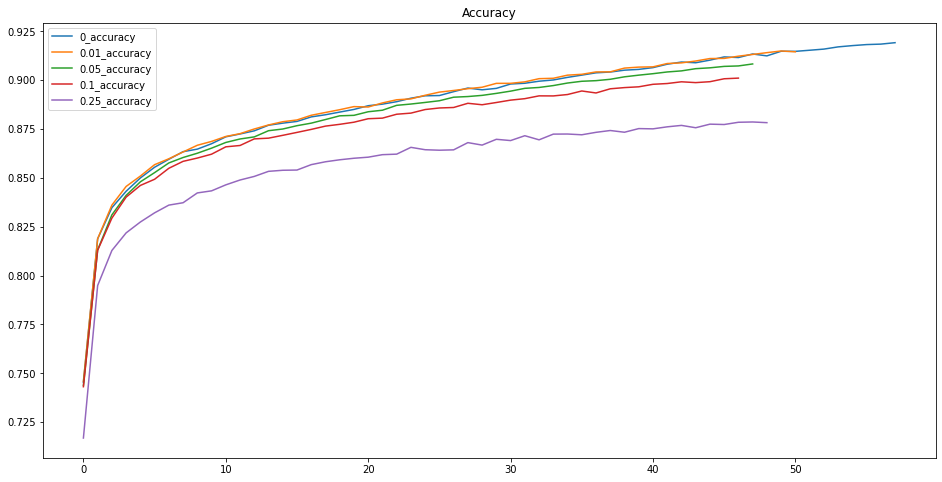

Лучшее кол-во эпох: 55               0_val_accuracy = 0.8841999769210815
Лучшее кол-во эпох: 49               0.01_val_accuracy = 0.8819000124931335
Лучшее кол-во эпох: 45               0.05_val_accuracy = 0.8784999847412109
Лучшее кол-во эпох: 44               0.1_val_accuracy = 0.8737000226974487
Лучшее кол-во эпох: 47               0.25_val_accuracy = 0.8610000014305115


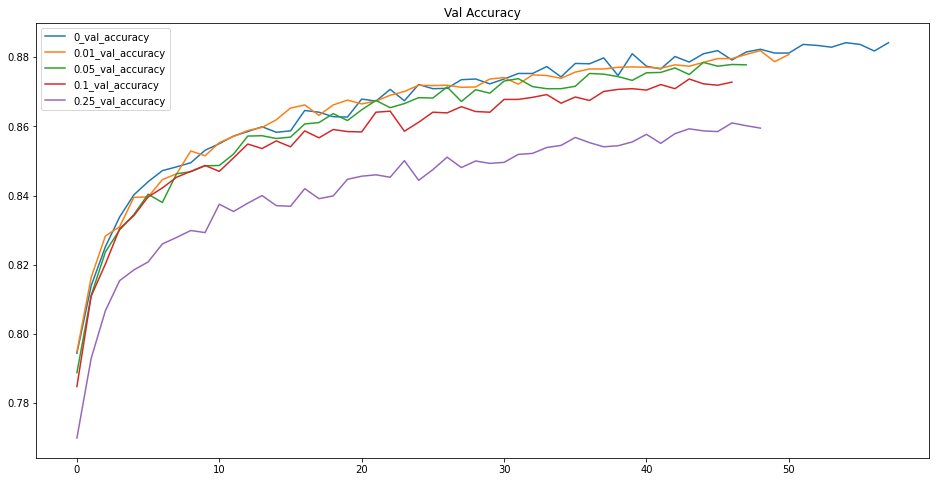

Лучшее кол-во эпох: 58               0_loss = 0.22573506832122803
Лучшее кол-во эпох: 51               0.01_loss = 0.23964981734752655
Лучшее кол-во эпох: 48               0.05_loss = 0.25516876578330994
Лучшее кол-во эпох: 47               0.1_loss = 0.2725450098514557
Лучшее кол-во эпох: 49               0.25_loss = 0.329263836145401


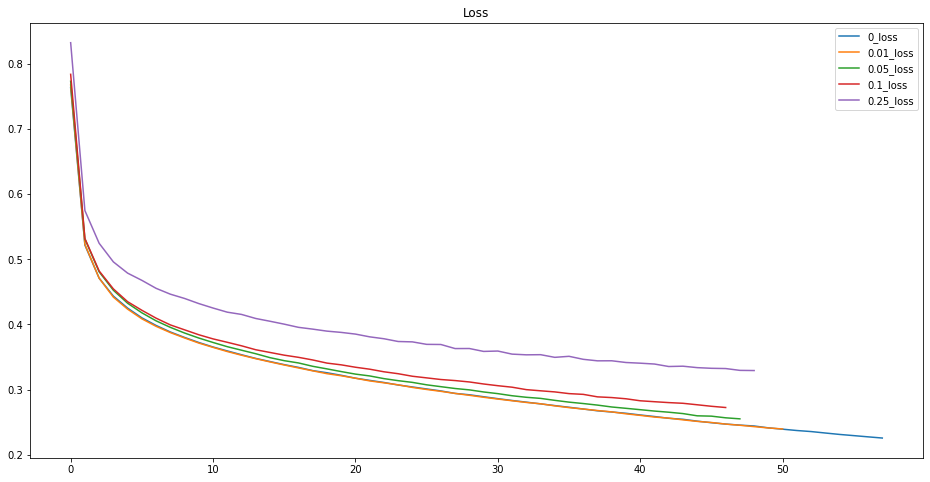

Лучшее кол-во эпох: 56               0_val_loss = 0.32967448234558105
Лучшее кол-во эпох: 51               0.01_val_loss = 0.3358375132083893
Лучшее кол-во эпох: 48               0.05_val_loss = 0.34142765402793884
Лучшее кол-во эпох: 45               0.1_val_loss = 0.35132768750190735
Лучшее кол-во эпох: 47               0.25_val_loss = 0.3837018311023712


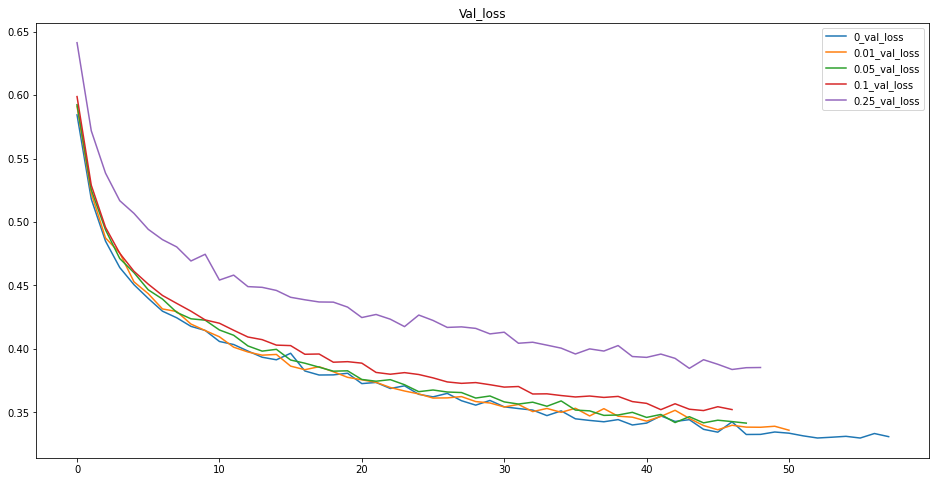

In [20]:
for std, hist in zip(std_list, histrory_gaus_list):
    show_stats(hist, 'accuracy', std)
plt.title('Accuracy')
plt.legend()
plt.show()

for std, hist in zip(std_list, histrory_gaus_list):
    show_stats(hist, 'val_accuracy', std)
plt.title('Val Accuracy')
plt.legend()
plt.show()

 
for std, hist in zip(std_list, histrory_gaus_list):
    show_stats(hist, 'loss', std, False)
plt.title('Loss')
plt.legend()
plt.show()
    
for std, hist in zip(std_list, histrory_gaus_list):
    show_stats(hist, 'val_loss', std, False)
plt.title('Val_loss')
plt.legend()
plt.show()
    

#### Мой вывод на основе экспериментов:
После нескольких экспериментов можно сделать вывод, что добавление шума в пределах до std = 0,05 влияет на модель слабо, дальнейшее увеличение диспрерсии ведет к заметному ухудшению точности. 